In [61]:
    import jsonschema, aiohttp, asyncio, fnmatch, dataclasses, builtins, jsonschema, collections, networkx, pathlib, IPython, ruamel.yaml, \
    inspect, ujson as json, io, pandas, time, mimetypes, nbformat, aiofiles, aiohttp, nbformat, collections, functools, typing
    from toolz.curried import *
    mime = compose(first, mimetypes.guess_type, str)            
    Path = type(pathlib.Path(''))
    def get_data(x): return x.data
    IPython.display.HTML("""<style>#notebook-container, .container {width: 100%;}</style>""")



In [62]:
    @dataclasses.dataclass
    class Validate:
        data: object = ''
        callable: callable = None
        def __hash__(self): return hash(str(self.data))
        def __len__(self): return len(self.data)
        async def __call__(self, object): 
            if self.callable:
                object = self.callable(object) 
                if inspect.isawaitable(object): object = await object
            return str(object)
        
    class Mime(Validate, collections.UserString):
        def validate(self, object): 
            if isinstance(object, type(self)): return hash(object) == hash(self)
            return not self.data or self.data == mime(str(object))

In [63]:
    class Pattern(Mime, collections.UserList, str): 
        def validate(self, object): return any(fnmatch.fnmatch(str(object), pattern) for pattern in self.data)

In [64]:
    class Schema(jsonschema.Draft4Validator, Validate):
        @property
        def data(self): return self.schema
        def validate(self, object):
            if isinstance(object, type(self)): return hash(object) == hash(self)
            try: return super().validate(object) or True
            except jsonschema.ValidationError: return False
        async def __call__(self, object): return object
        
        @classmethod
        def new(cls, type):
            class Model(__import__('pydantic').BaseModel): object: type
            schema = json.loads(Model.schema_json())['properties']['object']
            return cls(schema.pop('title') and schema)

In [65]:
    ForwardRef = getattr(typing, 'ForwardRef', typing._ForwardRef)

In [130]:
    class Composition(networkx.DiGraph):
        async def paths(self, target, object, source=None):
            paths = []
            try: mro = list(inspect.getmro(source or type(object)))
            except AttributeError: mro = [source]
            while mro:
                klass, path_ = mro.pop(0), []
                if klass is builtins.object: break
                for method in (networkx.all_simple_paths, networkx.all_shortest_paths):
                    try: paths += [object[:2] for object in method(self, klass, target) if len(object)>1]
                    except (networkx.NodeNotFound, networkx.NetworkXNoPath): ...
            paths = pipe(paths, map(tuple), groupby(compose(flip(isinstance)(Validate), second)), valmap(compose(list, unique)))
            return paths.get(True, []), paths.get(False, [])
        
        async def advance(self, *targets, object):
            for target in targets:
                callable, target = target, target.func if isinstance(target, functools.partial) else target

                if target not in self: object = target(object); continue
                
                source = type(object)

                try: 
                    if not networkx.has_path(self, source, target): continue
                except networkx.NodeNotFound: continue
                
                callable, target = target, target.func if isinstance(target, functools.partial) else target
                
                prior, (validators, paths) = object, await self.paths(target, object, source=source)
                if not (validators or paths): continue
                
                for this, next in validators:
                    if next.validate(object): 
                        object, (this, next, *_) = await next(object), networkx.shortest_path(self, next, target)
                        break
                else:
                    for this, next in paths: break
                                                
                if next == target: next = callable    
                if next is builtins.object: continue
                
                object = next() if object is None else next(object)                
                if inspect.isawaitable(object): object = await object
                
                if next == target: continue
                elif isinstance(target, type):
                    if isinstance(source, target): continue
                else:
                    try:
                        if object == target: continue
                    except ValueError: ...
                object = await self.advance(target, object=object)      
            return object
        
        async def text(self, path, attr='text', **kwargs):
            if isinstance(path, pathlib.Path):
                async with aiofiles.open(path, mode='r') as file: return await file.read()
            global session
            async with session.get(str(path), **kwargs) as response: return await response.text()
            
        async def json(self, path, attr='text', **kwargs):
            if isinstance(path, pathlib.Path):
                async with aiofiles.open(path, mode='r') as file: return json.loads(await file.read())
            global session
            async with session.get(str(path), **kwargs) as response: 
                try: return await response.json(content_type=None)
                except BaseException as Exception: return Exception
        
        async def __call__(self, target, *object, keys=True, cache=True, **data, ):
            global session
            key, value = [], []
            if not object: object = None,
            if not isiterable(target): target = target,
            async with aiohttp.ClientSession() as session:
                for object in object:
                    original = identity
                    if isinstance(object, str):
                        original = str
                        for pattern in pipe(ado.nodes, filter(flip(isinstance)(Pattern)), list):
                            if pattern.validate(object): object = collections.UserString(object); break
                        else:
                            try: 
                                path = pathlib.Path(object)
                                if path.exists(): object = path
                                else: object = collections.UserString(object)
                            except:...                                  
                    key.append(original(object)), value.append(self.advance(*target, object=object))
                value = await asyncio.gather(*value)
            if keys: return dict(zip(key, value))
            return value

In [131]:
    def series_to_frame(series):
        if series.dtypes == pandas.np.dtype('O'): return series.apply(pandas.Series)
        return series.to_frame()

In [132]:
    mimetypes.add_type('text/markdown', '.md')
    mimetypes.add_type('text/markdown', '.markdown')
    mimetypes.add_type('application/x-sqlite3', '.sqlite')
    mimetypes.add_type('application/x-yaml', '.yml')
    mimetypes.add_type('application/x-yaml', '.yaml')

In [164]:
    Web = Pattern(['http://*', 'https://*'])
    core = Composition()
    core.add_path([Path, core.text, str])
    
    core.add_path([Path, core.json, dict, json.dumps, str])
    core.add_path([Path, core.json, list, json.dumps])
    core.add_path([Path, core.json, int, json.dumps])
    core.add_path([Path, core.json, float, json.dumps])
    core.add_path([collections.UserString, Web, core.text, str])
    core.add_path([collections.UserString, Web, core.json, dict])
    core.add_path([collections.UserString, Web, core.json, list])
    core.add_path([collections.UserString, Web, core.json, float])
    core.add_path([collections.UserString, Web, core.json, int])
    
    display = Composition()
    display.add_path([dict, IPython.display.JSON])
    display.add_path([list, IPython.display.JSON])
    display.add_path([str, IPython.display.Code])
    display.add_path([str, IPython.display.Markdown, __import__('mistune').markdown, IPython.display.HTML])
    display.add_path([str, IPython.display.HTML])
    display.add_path([str, IPython.display.SVG])
    

    pd = Composition()
    pd.add_path([collections.UserString, Mime('text/csv'), pandas.read_csv])
    pd.add_path([Path, Mime('text/csv'), pandas.read_csv, pandas.DataFrame])
    pd.add_path([dict, pandas.Series])
    pd.add_path([pandas.Series, series_to_frame, pandas.DataFrame])
    pd.add_path([list, pandas.DataFrame, pandas.DataFrame.T])
    mimetypes.add_type('application/x-yaml', '.yml')
    mimetypes.add_type('application/x-yaml', '.yaml')

    yaml = Composition()
    yaml.add_path([Path, Mime('application/x-yaml', callable=yaml.text), io.StringIO, __import__('yaml').safe_load])
    yaml.add_path([collections.UserString, compose(io.StringIO, str), __import__('yaml').safe_load, str])
    yaml.add_path([__import__('yaml').safe_load, dict])
    yaml.add_path([__import__('yaml').safe_load, list])
    yaml.add_path([__import__('yaml').safe_load, float])
    yaml.add_path([__import__('yaml').safe_load, int])
    
    import graphviz
    nx = Composition()
    nx.add_path([dict, Schema.new(typing.Dict[str, list]), partial(networkx.from_dict_of_lists, create_using=networkx.DiGraph), networkx.DiGraph])
    nx.add_path([dict, Schema.new(typing.Dict[str, dict]), partial(networkx.from_dict_of_dicts, create_using=networkx.DiGraph), networkx.DiGraph])
    nx.add_path([dict, Schema.new(typing.Dict[str, list]), networkx.from_dict_of_lists, networkx.Graph])
    nx.add_path([dict, Schema.new(typing.Dict[str, dict]), networkx.from_dict_of_dicts, networkx.Graph])
    nx.add_path([networkx.DiGraph, networkx.nx_pydot.to_pydot, networkx.nx_pydot._import_pydot().Dot, graphviz.Source, graphviz.Source._repr_svg_, str])    
    nx.add_path([networkx.Graph, networkx.nx_pydot.to_pydot])    
    
    
    ado = networkx.compose_all((nx, yaml, pd, display, core))    

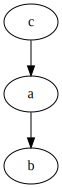

In [167]:
    first(await ado(graphviz.Source, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

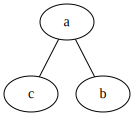

In [166]:
    first(await ado((networkx.Graph, graphviz.Source), """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

In [159]:
    await ado(str, 'data.json')

{'data.json': '{"index":{"0":"ZRRVgPxAbg","1":"qGdbMygKUl","2":"MFEpsjeg81","3":"Bc5QYEyyvO","4":"HmTeNtf2KE","5":"64XpwGGKX4","6":"FDGUaeSGrl","7":"9bnZ4FYWx2","8":"AwjEKKungG","9":"NXaBII16Fj","10":"qEIcjlnGHI","11":"1fNnWbStZw","12":"bnvkbltHLG","13":"P7xLisuKVA","14":"gsDI04CK8A","15":"U8BBDbZX1G","16":"mbWrBDgX04","17":"ECjFSyUkpB","18":"OX5VFucfeX","19":"l7KVkLide0","20":"xwTl85EoQF","21":"vXzvHqbkN9","22":"HIVHjSMo0C","23":"2P90ZEkuB4","24":"t78MDAdN8q","25":"twVQDkT4Ml","26":"J3Xm342gpK","27":"A0PPGcOKtR","28":"NnuL0L7diK","29":"Q8ZNWO1pjT"},"A":{"0":-1.1381053526,"1":0.9321689226,"2":-0.2780034718,"3":-0.3152962554,"4":-0.4149500832,"5":-1.2930293485,"6":0.0666344786,"7":-1.3286309582,"8":0.8666398435,"9":0.4146053432,"10":2.1906356518,"11":-0.5081963836,"12":-0.7752061834,"13":-1.1201804519,"14":1.1346744557,"15":1.0586798474,"16":0.1525046686,"17":0.1177851626,"18":-1.6120342787,"19":-0.0934465677,"20":0.3759729267,"21":-0.6660882425,"22":-1.8270546823,"23":-0.6243323481,"24

In [135]:
    await ado(dict, 'data.json')

{'data.json': {'index': {'0': 'ZRRVgPxAbg',
   '1': 'qGdbMygKUl',
   '2': 'MFEpsjeg81',
   '3': 'Bc5QYEyyvO',
   '4': 'HmTeNtf2KE',
   '5': '64XpwGGKX4',
   '6': 'FDGUaeSGrl',
   '7': '9bnZ4FYWx2',
   '8': 'AwjEKKungG',
   '9': 'NXaBII16Fj',
   '10': 'qEIcjlnGHI',
   '11': '1fNnWbStZw',
   '12': 'bnvkbltHLG',
   '13': 'P7xLisuKVA',
   '14': 'gsDI04CK8A',
   '15': 'U8BBDbZX1G',
   '16': 'mbWrBDgX04',
   '17': 'ECjFSyUkpB',
   '18': 'OX5VFucfeX',
   '19': 'l7KVkLide0',
   '20': 'xwTl85EoQF',
   '21': 'vXzvHqbkN9',
   '22': 'HIVHjSMo0C',
   '23': '2P90ZEkuB4',
   '24': 't78MDAdN8q',
   '25': 'twVQDkT4Ml',
   '26': 'J3Xm342gpK',
   '27': 'A0PPGcOKtR',
   '28': 'NnuL0L7diK',
   '29': 'Q8ZNWO1pjT'},
  'A': {'0': -1.1381053526,
   '1': 0.9321689226000001,
   '2': -0.2780034718,
   '3': -0.3152962554,
   '4': -0.41495008320000004,
   '5': -1.2930293485,
   '6': 0.0666344786,
   '7': -1.3286309582,
   '8': 0.8666398435,
   '9': 0.41460534320000003,
   '10': 2.1906356518,
   '11': -0.5081963836,

In [137]:
    first(await ado(networkx.DiGraph, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

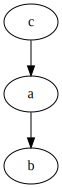

In [138]:
    first(await ado(graphviz.Source, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

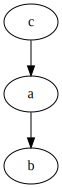

In [139]:
    first(await ado(IPython.display.SVG, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False))

In [140]:
    type(first(await ado(IPython.display.SVG, """
    a:
        b: 
            c: 1
            
    c: 
        a: {}""", keys=False)))

IPython.core.display.SVG

In [141]:
    (await ado((dict, pandas.Series), 'data.json', keys=False))

[index    {'0': 'ZRRVgPxAbg', '1': 'qGdbMygKUl', '2': 'M...
 A        {'0': -1.1381053526, '1': 0.9321689226000001, ...
 B        {'0': -0.5542260677, '1': 0.0662085087, '2': 0...
 C        {'0': -0.3036040043, '1': -1.1248441326, '2': ...
 D        {'0': -0.3045712968, '1': 1.1846076177, '2': -...
 dtype: object]

In [142]:
    (await ado(pandas.Series, 'data.json', keys=False))

[index    {'0': 'ZRRVgPxAbg', '1': 'qGdbMygKUl', '2': 'M...
 A        {'0': -1.1381053526, '1': 0.9321689226000001, ...
 B        {'0': -0.5542260677, '1': 0.0662085087, '2': 0...
 C        {'0': -0.3036040043, '1': -1.1248441326, '2': ...
 D        {'0': -0.3045712968, '1': 1.1846076177, '2': -...
 dtype: object]

In [143]:
    pandas.concat(await ado(pandas.DataFrame, 'https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv', 'iris.csv'), axis=1).T

0    \
https://raw.githubusercontent.com/uiuc-cse/data... sepal_length          5.1   
                                                   sepal_width           3.5   
                                                   petal_length          1.4   
                                                   petal_width           0.2   
                                                   species            setosa   
iris.csv                                           Unnamed: 0         setosa   
                                                   sepal length (cm)     5.1   
                                                   sepal width (cm)      3.5   
                                                   petal length (cm)     1.4   
                                                   petal width (cm)      0.2   

                                                                         1    \
https://raw.githubusercontent.com/uiuc-cse/data... sepal_length          4.9   
                                                   sepal_width             3   
                                                   petal_length          1.4   
                                                   petal_width           0.2   
                                                   species            setosa   
iris.csv                                           Unnamed: 0         setosa   
                                                   sepal length (cm)     4.9   
                                                   sepal width (cm)        3   
                                                   petal length (cm)     1.4   
                                                   petal width (cm)      0.2   

                                                                         2    \
https://raw.githubusercontent.com/uiuc-cse/data... sepal_length          4.7   
                                                   sepal_width           3.2   
                                                   petal_length          1.3   
                                                   petal_width           0.2   
                                                   species            setosa   
iris.csv                                           Unnamed: 0         setosa   
                                                   sepal length (cm)     4.7   
                                                   sepal width (cm)      3.2   
                                                   petal length (cm)     1.3   
                                                   petal width (cm)      0.2   

                                                                         3    \
https://raw.githubusercontent.com/uiuc-cse/data... sepal_length          4.6   
                                                   sepal_width           3.1   
                                                   petal_length          1.5   
                                                   petal_width           0.2   
                                                   species            setosa   
iris.csv                                           Unnamed: 0         setosa   
                                                   sepal length (cm)     4.6   
                                                   sepal width (cm)      3.1   
                                                   petal length (cm)     1.5   
                                                   petal width (cm)      0.2   

                                                                         4    \
https://raw.githubusercontent.com/uiuc-cse/data... sepal_length            5   
                                                   sepal_width           3.6   
                                                   petal_length          1.4   
                                                   petal_width           0.2   
                                                   species            setosa   
iris.csv                                           Unnamed: 0        

In [144]:
    await ado(dict, Path('.travis.yml'))

{PosixPath('.travis.yml'): {'language': 'python',
  'python': ['3.6', '3.6-dev'],
  'install': ['python setup.py sdist bdist_wheel',
   'pip install -r requirements.txt',
   'python -m pip install dist/nostalgiaforever-*.tar.gz --ignore-installed --no-deps'],
  'script': ['ipython --config nostalgiaforever/ipyconfig.py -m pytest nostalgiaforever/formal.ipynb',
   'ipython --config nostalgiaforever/ipyconfig.py -m unittest tests',
   'ipython profile create',
   'importnb-install',
   'ipython -m readme'],
  'deploy': {'provider': 'pypi',
   'user': 'docfast',
   'password': {'secure': 'GP4oO4GTNoTeGz++XDHSdMi4dexgVcqr5X5xmTs2m+Ol7YAFWcWhJqK7oXSh1JUZVAq7wm9mZf2uj9HUrJGiVrmplvQ94Z0LNDpvSrhNsPWGLfMltp5teYQ1EaVYNvVyaAQmQutbDUlms9BP6m1pr4eVDTIKzX+lz0UC4f4poZdJq1EfRCPMxOIyy4PXObMxlOllwH9gvLV7fRXrbgvMJg0skD2HTvmlLRjfSPsk6roiAwbodUOCYx7+KnnLpqh3OEeN3sCQzwi6rYIn31YWZg4DYXslR9ehaEXOzFuOLpOqX/0OxWasY2YDxlwCcUY0i3/7SFUAjrhxUTjteErEFmXiD0SrMY1SaFCWzT3AqY5jRO51OkqrmaWQW0oc3AV+joVraUo6Ud59bVoPLUVQQmp

In [86]:
    await ado((dict, type), pathlib.Path('fastapi-openapi-context.ipynb'))

{PosixPath('fastapi-openapi-context.ipynb'): dict}

In [146]:
    t = time.time()
    notebooks = pandas.concat(await ado(pandas.Series, *pathlib.Path().glob('*.ipynb'))).unstack(-1)
    print(time.time()-t)
    notebooks.sample(3).T.dropna(how='all').sample(3).rename_axis(index='cell number')

1.255802869796753


,2019-07-06-Untitled1-Copy1.ipynb,Untitled134.ipynb,Untitled130.ipynb
cell number,,,
nbformat,4,4,4
nbformat_minor,2,2,2
metadata,"{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag...","{'kernelspec': {'display_name': 'p6', 'languag..."


In [147]:
    notebooks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, 2018-06-16-Exploring-past-gist.ipynb to Δ.ipynb
Data columns (total 4 columns):
cells             448 non-null object
metadata          448 non-null object
nbformat          448 non-null object
nbformat_minor    448 non-null object
dtypes: object(4)
memory usage: 17.5+ KB


In [148]:
    t = time.time()
   
    gists = pandas.concat(
       await ado(pandas.DataFrame, *(F"""https://api.github.com/users/tonyfast/gists?page={_}""" for _ in range(1, 30)), keys=False))
    print(time.time()-t)


0.8105380535125732


In [149]:
    files = gists.files.apply(pandas.Series).stack().apply(pandas.Series)

In [150]:
    files.language.value_counts()

Jupyter Notebook    407
Markdown             79
HTML                 71
Python               52
Text                 46
YAML                 33
MATLAB               25
JavaScript           25
JSON                 15
CSV                   9
CoffeeScript          7
SVG                   5
CSS                   4
Graphviz (DOT)        2
TypeScript            2
Limbo                 1
Smarty                1
XML                   1
Name: language, dtype: int64

In [151]:
    gists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590 entries, 0 to 19
Data columns (total 18 columns):
comments        590 non-null int64
comments_url    590 non-null object
commits_url     590 non-null object
created_at      590 non-null object
description     575 non-null object
files           590 non-null object
forks_url       590 non-null object
git_pull_url    590 non-null object
git_push_url    590 non-null object
html_url        590 non-null object
id              590 non-null object
node_id         590 non-null object
owner           590 non-null object
public          590 non-null bool
truncated       590 non-null bool
updated_at      590 non-null object
url             590 non-null object
user            0 non-null object
dtypes: bool(2), int64(1), object(15)
memory usage: 99.5+ KB


In [154]:
    remote = gists.files.apply(pandas.Series).stack().apply(pandas.Series).set_index('language').loc['Jupyter Notebook']

    remote = await ado(pandas.DataFrame, *remote.raw_url[:50].values)

In [155]:
    pipe(remote, valfilter(flip(isinstance)(pandas.DataFrame)), partial(pandas.concat, sort=False, axis=1)).T.sample(4)

,,cells,metadata,nbformat,nbformat_minor
https://gist.githubusercontent.com/tonyfast/425f3ee458a32d85a37531a5169d1c24/raw/fb48698e98424dda79a32131d700ed71c8f6d72f/vvvvv.ipynb,6,"{'cell_type': 'code', 'execution_count': 9, 'm...",NaN,NaN,NaN
https://gist.githubusercontent.com/tonyfast/87918125d3b0f2b5ee99f918c99fc708/raw/d3a1396c8bccd7014fcb71ede08aa79a9748ee03/hacking-odo-for-2019.ipynb,4,"{'cell_type': 'code', 'execution_count': 41, '...",NaN,NaN,NaN
https://gist.githubusercontent.com/tonyfast/8de80403256ead90b7a5e69c3fbc1ec5/raw/d83c58e4b7de54d5cf4d4ec5958d6dd346ecd1e5/github-rss-feeds-to-dataframe.ipynb,6,"{'cell_type': 'markdown', 'metadata': {}, 'sou...",NaN,NaN,NaN
https://gist.githubusercontent.com/tonyfast/1b6fc686eaa336f36bb8e04837f54ee3/raw/25e46502ce825bfae71b49f538cf873a884527d9/datashape-typing-system.ipynb,kernelspec,NaN,"{'display_name': 'p6', 'language': 'python', '...",NaN,NaN


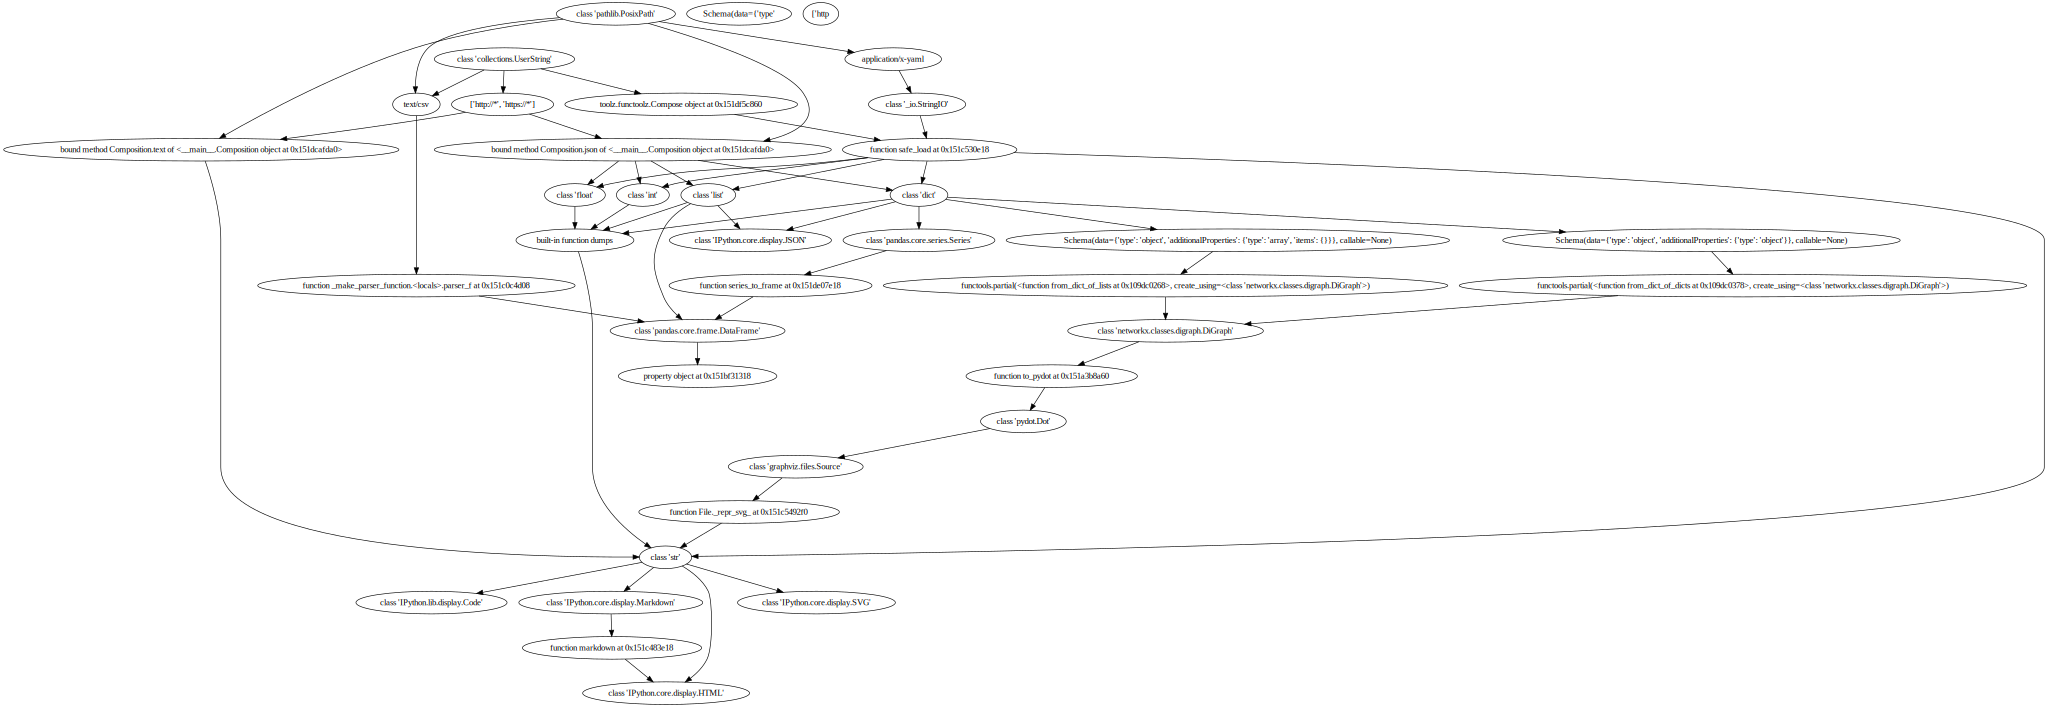

In [156]:
    pipe(ado, networkx.nx_pydot.to_pydot, operator.methodcaller('to_string'), __import__('graphviz').Source)
